# Variational Autoeconders for Cluster Membership Probability

In [239]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Cluster_analysis" in os.getcwd()):
    os.chdir("../Data_handling")

from pca_functions import Pca_Fitting
from gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from vae import Encoder,Decoder, VAE , loss_function, model_train
from sp_vae import ModelVAE,model_trains

os.chdir("../Cluster_analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Cluster_analysis'

In [240]:
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)  

In [241]:
os.chdir('../cluster_files')
vae_data=pd.read_csv('vae_data.csv')
os.chdir('../Cluster_analysis')

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_37120/820830294.py:2: DtypeWarning: Columns (11,12,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  vae_data=pd.read_csv('vae_data.csv')


For now we will drop the nan values for training the VAE

In [242]:
columns=['ra','dec','parallax','VRAD','pmra','pmdec','bp_g','g_rp',
'ra_error','dec_error','parallax_error','pmra_error','pmdec_error','phot_g_mean_flux'
,'mean_absolute_mag_g_band','bp_rp','prob'
,'parallax_over_error','phot_g_mean_flux_error','phot_bp_mean_flux_error','phot_rp_mean_flux_error'
,'phot_g_mean_flux_over_error','phot_bp_mean_flux_over_error','phot_rp_mean_flux_over_error','rgeo','phot_g_mean_mag']


In [243]:
vae_data=vae_data[columns].dropna().reset_index(drop=True)

# ERROR

In [244]:
vae_data=vae_data[vae_data['rgeo']<=5000].reset_index(drop=True)
vae_data=vae_data[vae_data['phot_g_mean_flux_error']<1000].reset_index(drop=True)
vae_data=vae_data[vae_data['phot_bp_mean_flux_error']<1000].reset_index(drop=True)
vae_data=vae_data[vae_data['phot_rp_mean_flux_error']<1000].reset_index(drop=True)
vae_data=vae_data[vae_data['pmra_error']<=0.45].reset_index(drop=True)
vae_data=vae_data[vae_data['pmdec_error']<=0.45].reset_index(drop=True)
vae_data=vae_data[vae_data['parallax_error']<=0.2].reset_index(drop=True)

In [245]:
from sklearn.preprocessing import  MinMaxScaler
import torch
scaler=MinMaxScaler()

In [246]:


column_names=['bp_rp','phot_g_mean_mag','bp_g','g_rp','pmra','pmdec']
#column_names=['ra','dec','parallax','pmra','pmdec','bp_rp','mean_absolute_mag_g_band']

column_names

['bp_rp', 'phot_g_mean_mag', 'bp_g', 'g_rp', 'pmra', 'pmdec']

In [247]:
#scaled_data=scaler.fit_transform(vae_data[['bp_rp','phot_g_mean_mag','rgeo','bp_g','g_rp']].values)
#scaled_data=scaler.fit_transform(vae_data[['bp_rp','mean_absolute_mag_g_band']].values)
scaled_data=vae_data[column_names].values
#scaled_data=vae_data[column_names].values

# Scaled, non inverted HR diagram

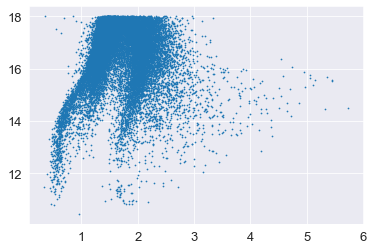

In [248]:
plt.scatter(scaled_data.transpose()[0],scaled_data.transpose()[1],s=0.5)

# Variational Autoencoder

In [249]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam
from torch.utils.data import DataLoader


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Latent parameters

In [250]:
batch_size = 4915 #617 #factor for 1090
lr = 1e-3
epochs = 1000
zdim=2

In [251]:
vae_dataset=DataLoader(torch.tensor(scaled_data).float(),batch_size=batch_size,drop_last=True) 

In [252]:
encoder = Encoder(input_dim=scaled_data.shape[1], hidden_dims=[50,5], z_dim=zdim,dropout=0.2)
decoder = Decoder(output_dim=scaled_data.shape[1], hidden_dims = [50,5], z_dim=zdim,dropout=0.2)
model = VAE(Encoder=encoder, Decoder=decoder).to(DEVICE)
optimizer=Adam(model.parameters(),lr=lr)

In [253]:
print("Start training VAE...")
model.train()
z_an,kld=model_train(vae_spec=vae_dataset,model=model,optimizer=optimizer,loss_function=loss_function,epochs=epochs,batch_size=batch_size)


Start training VAE...
	Epoch 1 complete! 	Average Loss:  2.022583496259325
Overall Loss:  29822.99365234375
KLD Loss:  tensor(3443.5781, grad_fn=<MulBackward0>)
	Epoch 2 complete! 	Average Loss:  0.29351565314778316
Overall Loss:  4327.8883056640625
KLD Loss:  tensor(2461.1013, grad_fn=<MulBackward0>)
	Epoch 3 complete! 	Average Loss:  -0.9225546696178789
Overall Loss:  -13603.068603515625
KLD Loss:  tensor(1944.3557, grad_fn=<MulBackward0>)
	Epoch 4 complete! 	Average Loss:  -1.697053026449644
Overall Loss:  -25023.046875
KLD Loss:  tensor(1690.5391, grad_fn=<MulBackward0>)
	Epoch 5 complete! 	Average Loss:  -2.216698192183791
Overall Loss:  -32685.21484375
KLD Loss:  tensor(1617.3215, grad_fn=<MulBackward0>)
	Epoch 6 complete! 	Average Loss:  -2.5783052782722957
Overall Loss:  -38017.111328125
KLD Loss:  tensor(1601.3281, grad_fn=<MulBackward0>)
	Epoch 7 complete! 	Average Loss:  -2.853241035096643
Overall Loss:  -42071.0390625
KLD Loss:  tensor(1594.4661, grad_fn=<MulBackward0>)
	Ep

KeyboardInterrupt: 

### Look at the KLD of main model.

In [ ]:
for i in range (len(z_an)):
    z_an[i]=z_an[i].detach().numpy()

for i in range (len(kld)):
    kld[i]=kld[i].detach().numpy()    

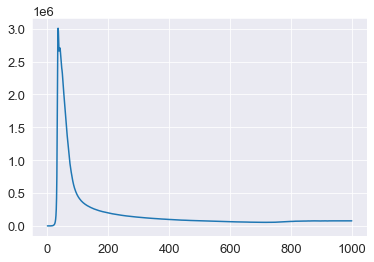

In [ ]:
plt.plot(kld)

# Model evaluations

In [ ]:
model.eval()
x_recon=model(torch.tensor(scaled_data).float())[0].detach().numpy()
zmean=model(torch.tensor(scaled_data).float())[1].detach().numpy()
z=model(torch.tensor(scaled_data).float())[3].detach().numpy()

# Compare the reconstructions

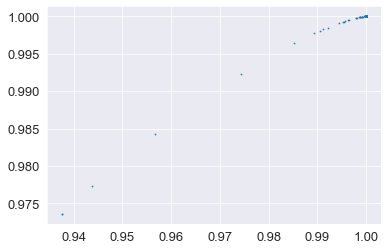

In [ ]:
plt.scatter(x_recon.transpose()[0], x_recon.transpose()[1],s=0.5)


In [ ]:
z_list=['z1','z2']

In [ ]:
vae_data[z_list]=z

<Figure size 1080x720 with 0 Axes>

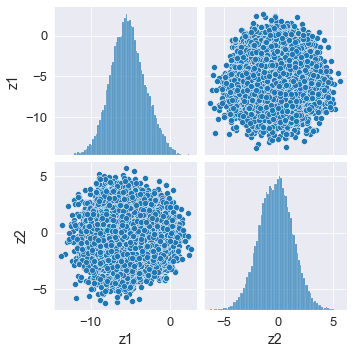

In [ ]:
plt.figure(figsize=(15,10))
sn.pairplot(vae_data[z_list[0:3]])


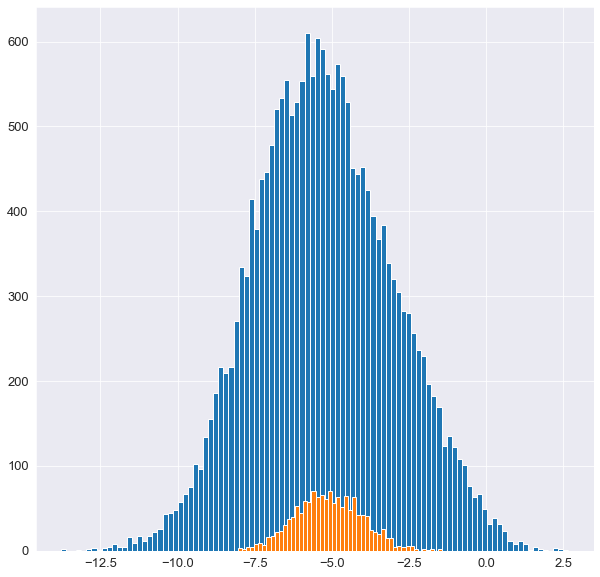

In [ ]:
fig = plt.figure(figsize=(10,10))



x=vae_data[vae_data['prob']<=0.9]
y=vae_data[vae_data['prob']>0.9]

plt.hist(x['z1'],bins=100)
plt.hist(y['z1'],bins=50)


plt.show()

<AxesSubplot:xlabel='z1', ylabel='z2'>

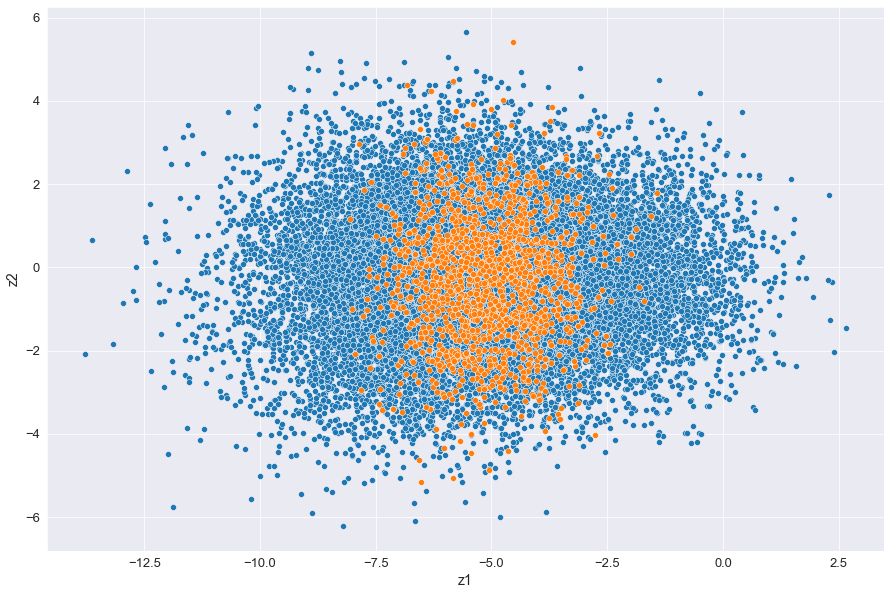

In [ ]:
plt.figure(figsize=(15,10))
sn.scatterplot(data=vae_data[vae_data['prob']<=0.9],x='z1',y='z2')
sn.scatterplot(data=vae_data[vae_data['prob']>0.9],x='z1',y='z2')

# Now let us see if we can cluster well on this latent space

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
gm = GaussianMixture(n_components=1 ,random_state=0).fit(vae_data[z_list].values)

In [ ]:
z_list

['z1', 'z2']

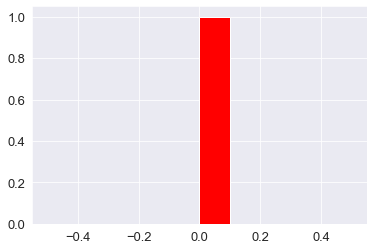

In [ ]:
i=0
plt.hist(gm.predict(vae_data[vae_data['prob']<=0.9][z_list].values).transpose()[i])
plt.hist(gm.predict(vae_data[vae_data['prob']>0.9][z_list].values).transpose()[i],color='r')
plt.show()

vae_data['prob2']=gm.predict(vae_data[z_list].values).transpose()[i]

This seems to be working okay.

Check it on a HR diagram

In [ ]:
data_for_hr1_full=vae_data[vae_data['prob2']>0.9]
data_for_hr2_full=vae_data[vae_data['prob']>0.9]
both_solution=data_for_hr1_full[vae_data['prob']>0.9]
data_for_hr1_full=data_for_hr1_full[data_for_hr1_full['prob']<=0.9]
data_for_hr2_full=data_for_hr2_full[data_for_hr2_full['prob2']<=0.9]

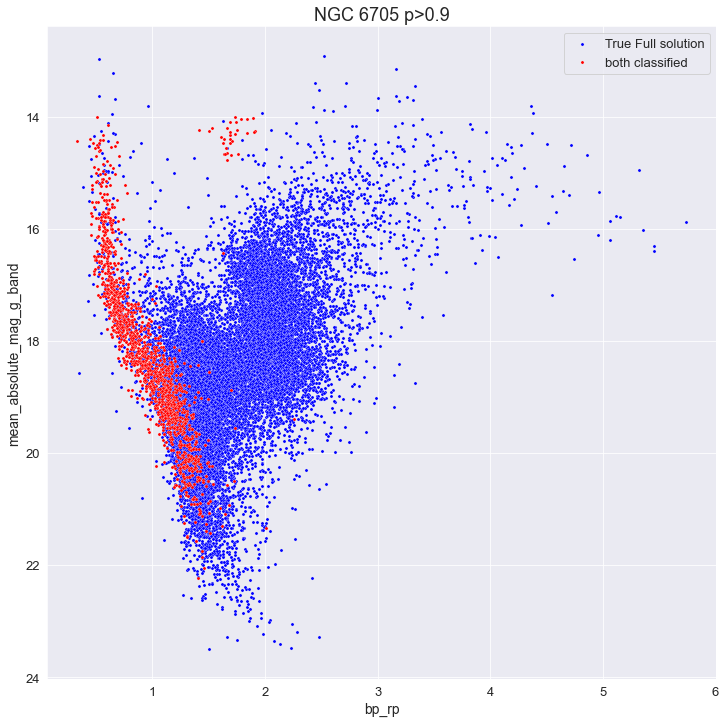

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

scatter=data_for_hr1_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,label='True Full solution',color='b')

scatter=data_for_hr2_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True astrometric',s=10,color='g')

scatter=both_solution
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='both classified',s=10,color='red')

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

<AxesSubplot:xlabel='pmra', ylabel='pmdec'>

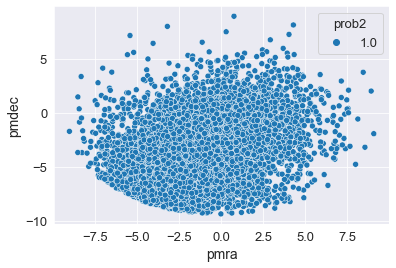

In [ ]:
sn.scatterplot(data=vae_data,x='pmra',y='pmdec',hue='prob2')